# Boltzmann Law: Physics to Computing

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(42)

## Core Functions - Binary Stochastic Neurons and Synapses

In [14]:
def sigmoid(x):
    """Sigmoid function (Fermi function)"""
    return 1.0 / (1.0 + np.exp(x))

def sample_neuron(x_tilde):
    """Binary stochastic neuron: n_r = θ(f_r - R_{0,1})"""
    f_r = sigmoid(-x_tilde)  # Fermi function
    return 1 if np.random.random() < f_r else 0

def calculate_x_tilde(r, n, x, W, higher_order=None):
    """Synapse: x_tilde_r = x_r + sum_q(w_rq * n_q)"""
    # External field
    x_tilde = x[r]
    
    # Add pairwise interactions
    for q in range(len(n)):
        if q != r:  # Avoid self-interaction
            x_tilde += W[r, q] * n[q]
    
    # Add higher-order interactions if provided
    if higher_order and r in higher_order:
        x_tilde += higher_order[r](n)
        
    return x_tilde

def calculate_energy(n, x, W, higher_order=None):
    """Calculate energy of the system"""
    # External field contribution
    energy = np.sum(x * n)
    
    # Pairwise interactions
    for r in range(len(n)):
        for q in range(r+1, len(n)):
            energy += W[r, q] * n[r] * n[q]
    
    # Higher-order interactions
    if higher_order:
        for r in range(len(n)):
            if r in higher_order:
                energy += n[r] * higher_order[r](n)
                
    return energy

## Time Sampling Implementation

In [15]:
def sequential_update(n, x, W, beta, higher_order=None):
    """Update neurons sequentially (required for Boltzmann distribution)"""
    n_new = n.copy()
    num_neurons = len(n)
    
    # Update each neuron sequentially
    for r in range(num_neurons):
        x_tilde = calculate_x_tilde(r, n_new, x, W, higher_order)
        x_tilde_scaled = beta * x_tilde  # Scale by inverse temperature
        n_new[r] = sample_neuron(x_tilde_scaled)
    
    return n_new

def simulate_system(num_steps, x, W, beta, higher_order=None):
    """Run time sampling simulation"""
    num_neurons = len(x)
    states = np.zeros((num_steps, num_neurons), dtype=int)
    energies = np.zeros(num_steps)
    
    # Start with random state
    n = np.random.randint(0, 2, size=num_neurons)
    
    # Run simulation
    for t in tqdm(range(num_steps)):
        states[t] = n
        energies[t] = calculate_energy(n, x, W, higher_order)
        n = sequential_update(n, x, W, beta, higher_order)
    
    return states, energies

In [16]:
def plot_time_series(states, energies, labels=None):
    """Visualize neuron states and energy over time"""
    num_steps, num_neurons = states.shape
    
    plt.figure(figsize=(12, 8))
    
    # Plot neuron states
    plt.subplot(2, 1, 1)
    for i in range(num_neurons):
        label = f"Neuron {i}" if labels is None else labels[i]
        plt.plot(states[:, i], label=label)
    
    plt.ylabel("State (0/1)")
    plt.title("Neuron States Over Time")
    plt.legend()
    plt.grid(True)
    
    # Plot energy
    plt.subplot(2, 1, 2)
    plt.plot(energies)
    plt.xlabel("Time Step")
    plt.ylabel("Energy")
    plt.title("System Energy Over Time")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_state_distribution(states):
    """Plot distribution of system states"""
    num_steps, num_neurons = states.shape
    
    # Convert binary states to integers
    state_ids = np.zeros(num_steps, dtype=int)
    for t in range(num_steps):
        for i in range(num_neurons):
            state_ids[t] += states[t, i] * (2 ** i)
    
    # Count state occurrences
    unique_states = np.arange(2**num_neurons)
    state_counts = np.zeros(len(unique_states))
    for s in state_ids:
        state_counts[s] += 1
    
    # Create binary state labels
    state_labels = [format(i, f'0{num_neurons}b') for i in unique_states]
    
    # Calculate theoretical probabilities (Boltzmann distribution)
    probabilities = state_counts / num_steps
    
    plt.figure(figsize=(12, 6))
    plt.bar(unique_states, probabilities)
    plt.xticks(unique_states, state_labels, rotation=90)
    plt.xlabel("System State (binary)")
    plt.ylabel("Probability")
    plt.title("State Distribution")
    plt.tight_layout()
    plt.show()

## Demonstration Scenarios

In [17]:
def demo_pairwise_system():
    """Demonstrate a simple system with pairwise interactions"""
    num_neurons = 3
    num_steps = 25
    
    # Compare high energy (low temperature) vs low energy (high temperature)
    for scenario, beta in [("High Energy (β=0.2)", 0.2), 
                          ("Low Energy (β=5.0)", 5.0)]:
        print(f"\n=== {scenario} ===")
        
        # External fields
        x = np.zeros(num_neurons)
        
        # Pairwise interaction weights (symmetric)
        W = np.array([
            [0.0, 1.0, 0.5],
            [1.0, 0.0, 0.5],
            [0.5, 0.5, 0.0]
        ])
        
        # Run simulation
        states, energies = simulate_system(num_steps, x, W, beta)
        
        # Visualize results
        plot_time_series(states, energies)
        plot_state_distribution(states)

def demo_higher_order_system():
    """Demonstrate system with higher-order interactions: E = x₃n₃ + n₁n₂n₃"""
    num_neurons = 3
    num_steps = 25
    
    # External field (only for neuron 3)
    x = np.array([0.0, 0.0, 0.5])
    
    # No pairwise interactions
    W = np.zeros((3, 3))
    
    # Higher-order interaction n₁n₂n₃
    higher_order = {
        2: lambda n: n[0] * n[1]  # Contribution to x_tilde_3 is n₁n₂
    }
    
    # Run simulation with moderate energy
    beta = 1.0
    states, energies = simulate_system(num_steps, x, W, beta, higher_order)
    
    # Visualize results
    plot_time_series(states, energies, labels=["n₁", "n₂", "n₃"])
    plot_state_distribution(states)

## Main

1. Demonstrating time sampling with pairwise interactions
   Comparing high vs. low energy regimes

=== High Energy (β=0.2) ===


100%|██████████| 25/25 [00:00<00:00, 21132.12it/s]


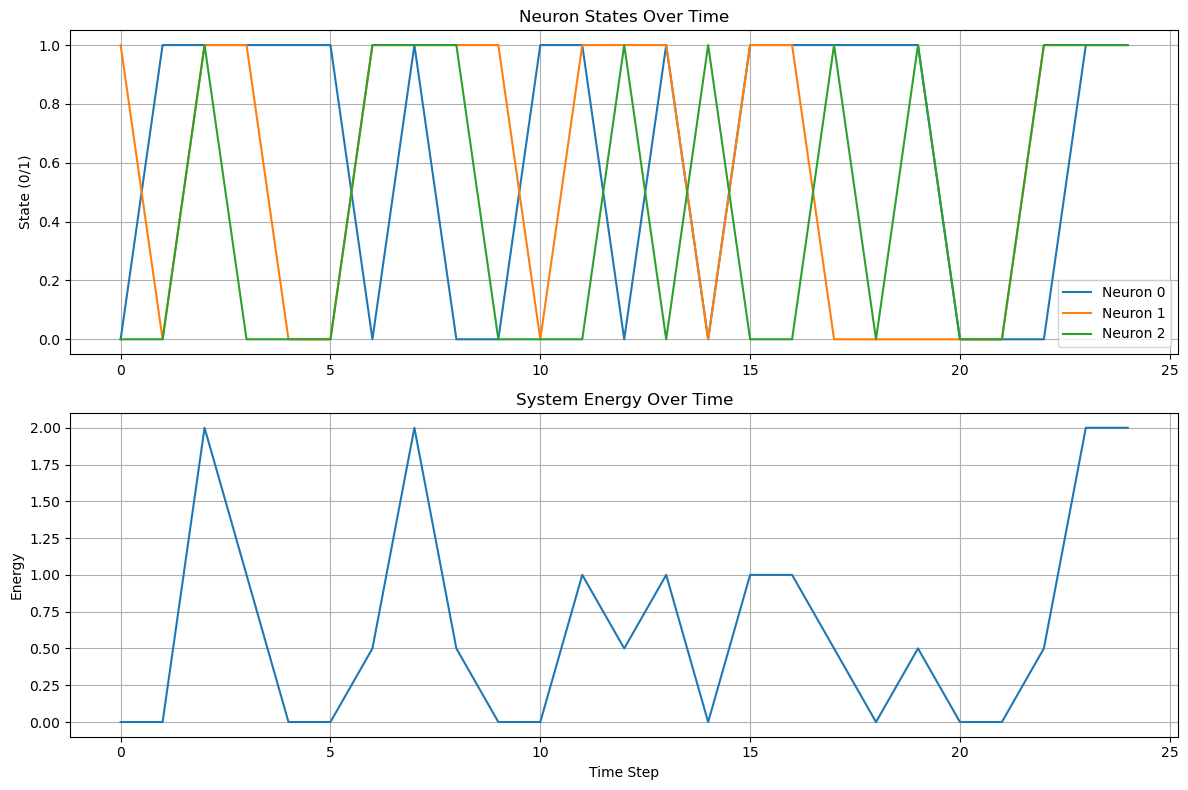

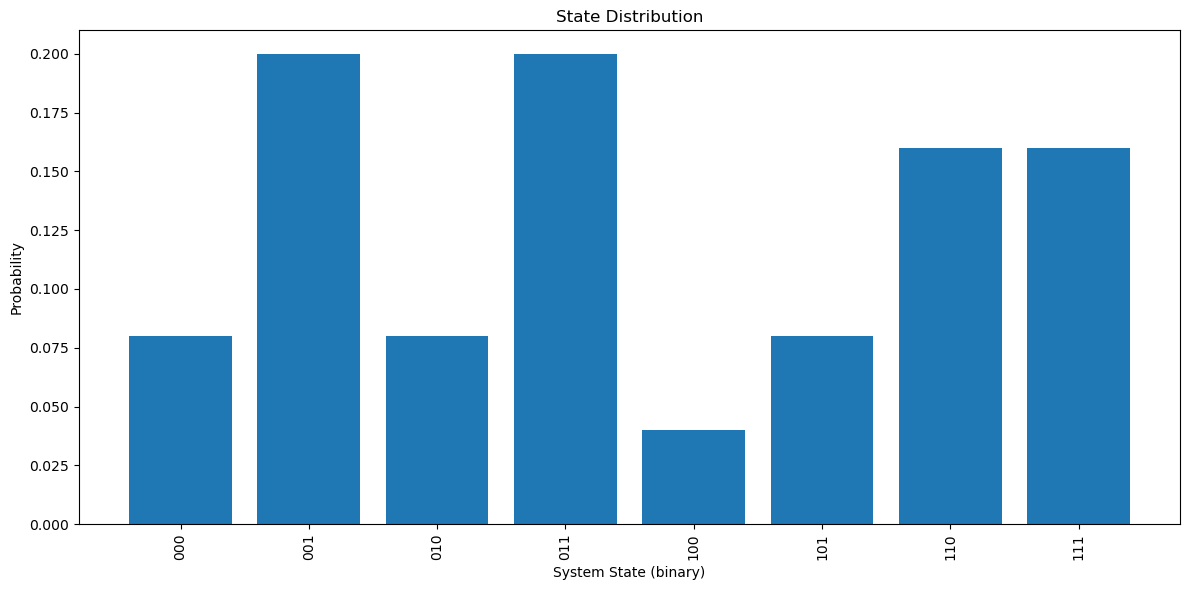


=== Low Energy (β=5.0) ===


100%|██████████| 25/25 [00:00<00:00, 65291.16it/s]


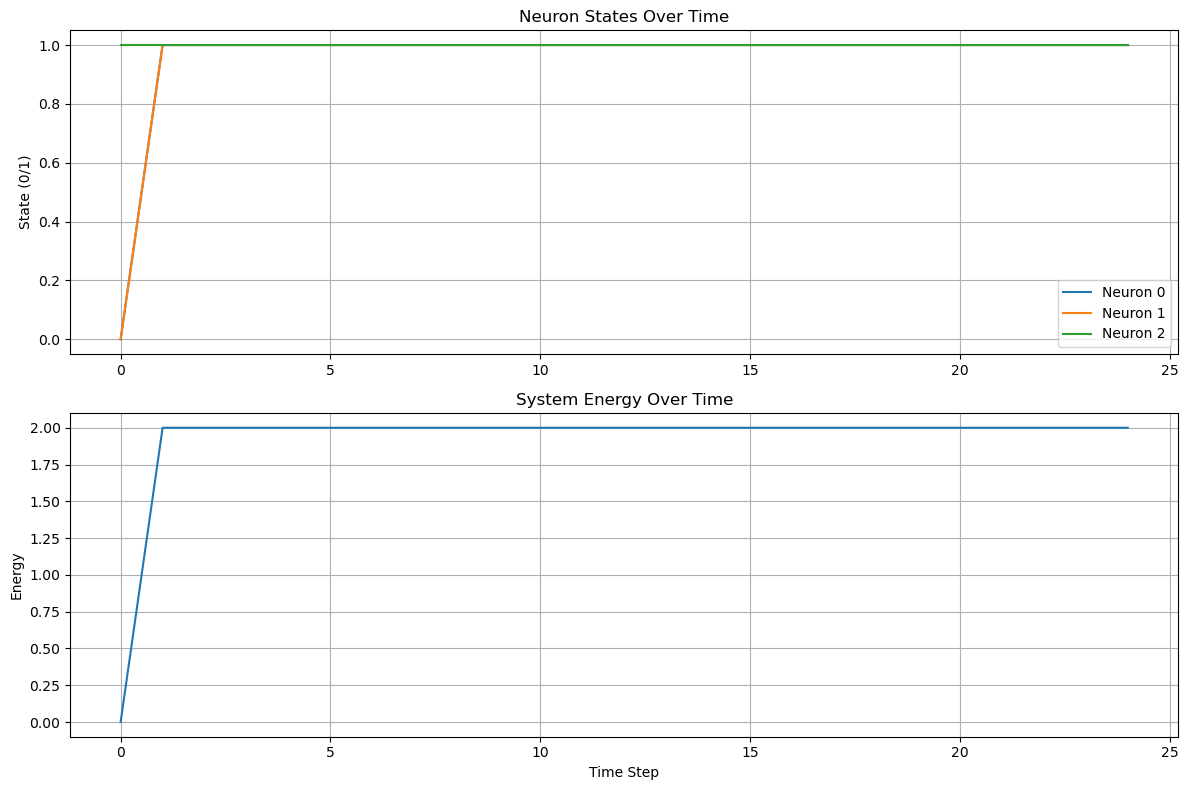

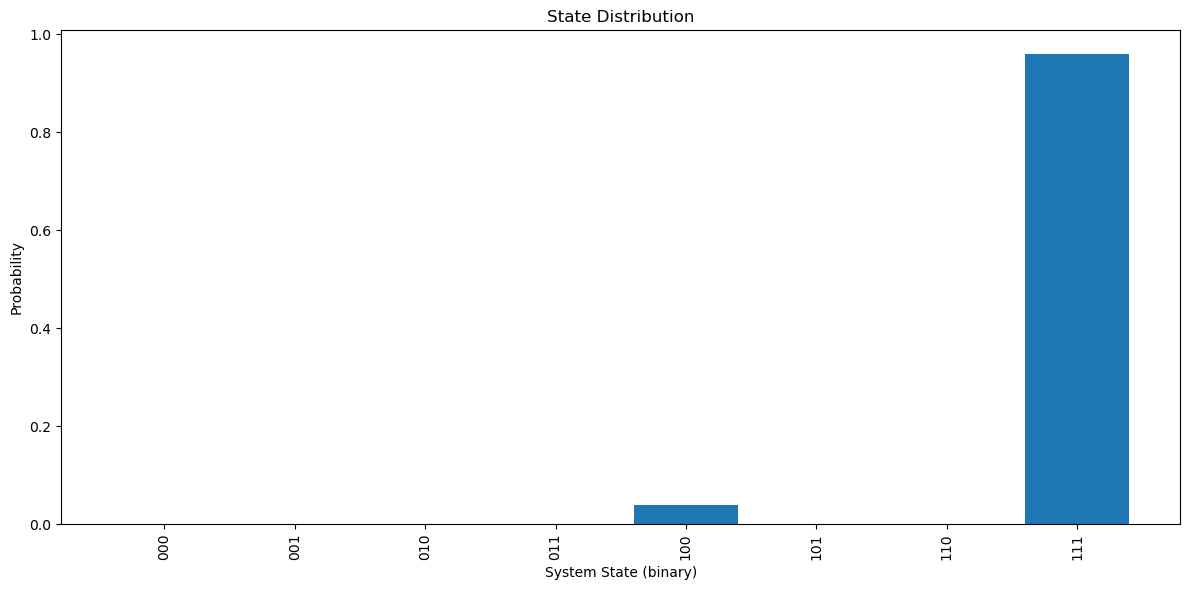


2. Demonstrating higher-order interaction: E = x₃n₃ + n₁n₂n₃


100%|██████████| 25/25 [00:00<00:00, 78781.07it/s]


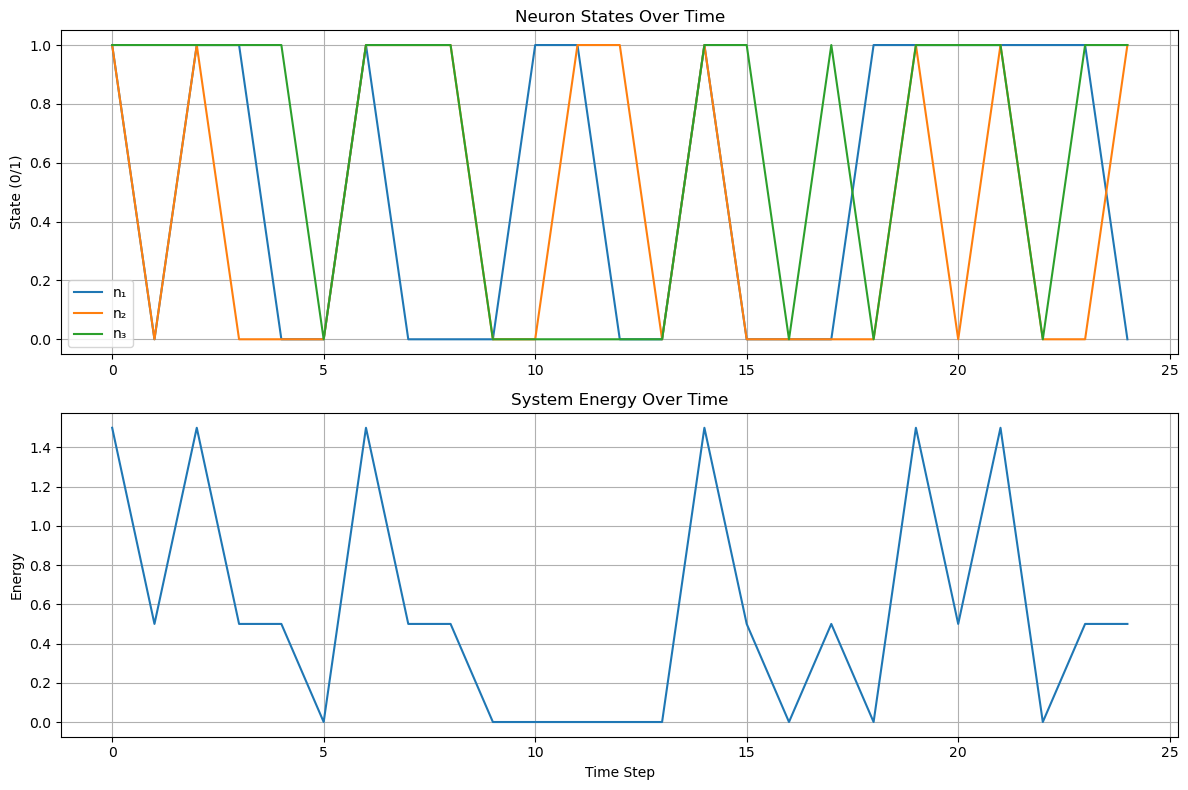

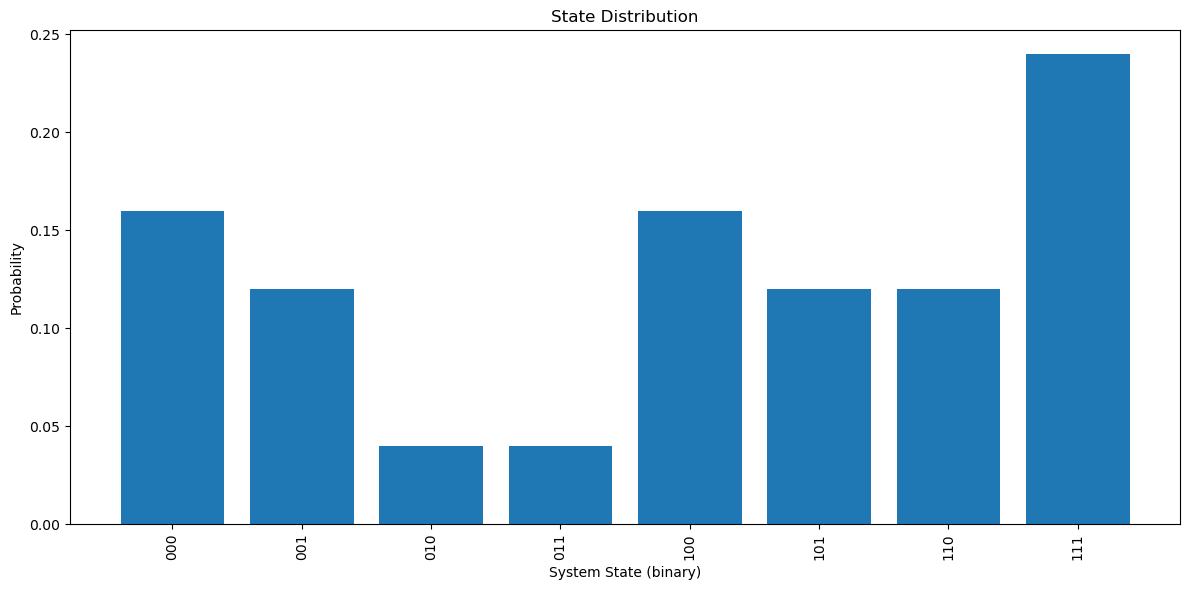

In [18]:
print("1. Demonstrating time sampling with pairwise interactions")
print("   Comparing high vs. low energy regimes")
demo_pairwise_system()

print("\n2. Demonstrating higher-order interaction: E = x₃n₃ + n₁n₂n₃")
demo_higher_order_system()